# Proof of Concept: General Adversarial Network

In order to show the inner-working of General Adversarial Networks, we must start extremely simple and work our way up. In this notebook, we will deviate from the normal experiments, in that we will simply demonstrate a basic GAN where a generator's weights will choose noise samples to try trick a discriminator that attempts to classify quadratic curves, generated by a simple numpy function.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def get_y(x):
    return 10 + x*x


def sample_data(n=10000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

def sample_Z(batch_size, dims):
    return np.random.uniform(-1., 1., size=[batch_size, dims])

Unlike previous notebooks, we will deviate away from the tensorflow Keras API for creating the networks, as we wish to access the raw layer outputs and use their logits and feature transformation outputs for plotting later.

We define our generator as two fully connected (dense) layers of 16 nodes each with a LeakyReLU activation function and an output layer of size two, corresponding to the dimensions of the real dataset we are trying to learn. The function will take in the placeholder variable for random samples, Z.

In [2]:
def generator(Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)

    return out

We define the discriminator in the same fashion. It is a 3 layer fully connected network, same activation functions, and takes in the placeholder for the sample vector space of the real data. It can also take in the generated samples from the generator network. The size of the third layer is fixed to 2 so we can plot the transformed feature space in a 2D plane, explained later.

The output of this function is a logit prediction for the given X and the output of the last layer (h3) which is the feature transformation learned for X. 
The logit function is the inverse of the sigmoid function, used to represent the logarithm of the odds (ratio of the probability of variable being 1 to that of it being 0).

In [3]:
def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3

For training, we define X and Z as placeholders for the real and generated noise data respectively.

In [4]:
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

We then use the functions and placeholders defined above to generate the graph for the generator network and feed real and generated data to the discriminator network.

In [5]:
G_sample = generator(Z)
r_logits, r_h3 = discriminator(X)
f_logits, g_h3 = discriminator(G_sample,reuse=True)

Using the logits for the real and generated data we can define the loss functions for the discriminator and generator repsectively.

These losses are sigmoid cross entropy based losses using the equations we defined above. It takes as input the discriminator logits and true labels for each sample. It then calculates the error for each sample.

In [6]:
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))


Next, we define optimizers for the two networks using the loss functions defined above and the scope of the layers defined in the generator and discriminator functions. We use the Adam optimizer for both the networks with the learning rate as 0.001.

In [7]:
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="discriminator")

gen_train_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars)
disc_train_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars)

Finally, we train each network in alternation for the required number of steps.

Iterations: 0	 Discriminator loss: 0.6853	 Generator loss: 0.7149


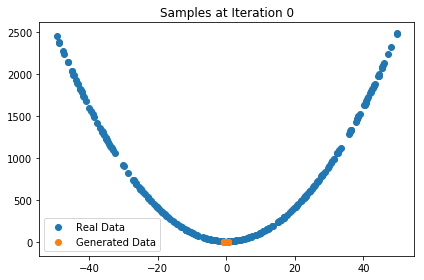

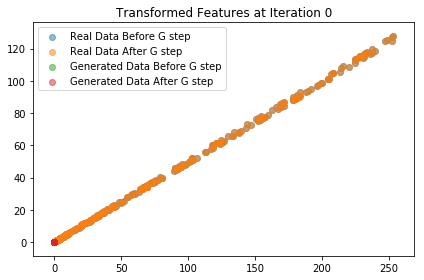

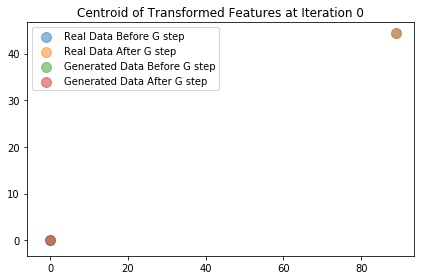

Iterations: 100	 Discriminator loss: 0.7265	 Generator loss: 2.2965
Iterations: 200	 Discriminator loss: 4.6408	 Generator loss: 0.0000
Iterations: 300	 Discriminator loss: 3.9712	 Generator loss: 0.0595
Iterations: 400	 Discriminator loss: 1.6518	 Generator loss: 2.6193
Iterations: 500	 Discriminator loss: 1.3915	 Generator loss: 0.7868
Iterations: 600	 Discriminator loss: 1.3718	 Generator loss: 0.6829
Iterations: 700	 Discriminator loss: 1.3471	 Generator loss: 0.5784
Iterations: 800	 Discriminator loss: 1.2390	 Generator loss: 0.6181
Iterations: 900	 Discriminator loss: 1.2051	 Generator loss: 0.6491
Iterations: 1000	 Discriminator loss: 1.0939	 Generator loss: 0.7520


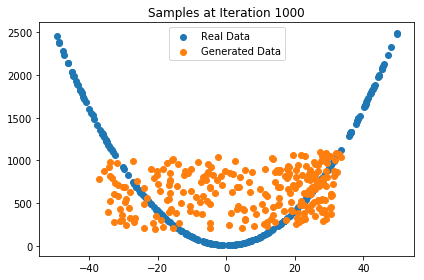

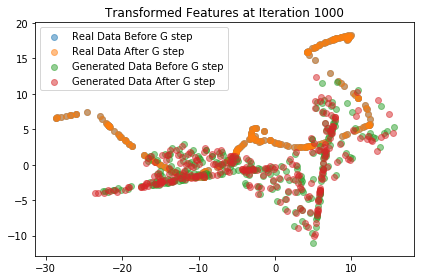

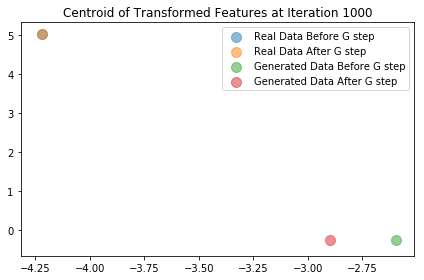

Iterations: 1100	 Discriminator loss: 1.1932	 Generator loss: 0.7103
Iterations: 1200	 Discriminator loss: 1.0922	 Generator loss: 0.7914
Iterations: 1300	 Discriminator loss: 1.1135	 Generator loss: 0.7881
Iterations: 1400	 Discriminator loss: 1.0521	 Generator loss: 1.0238
Iterations: 1500	 Discriminator loss: 1.0204	 Generator loss: 0.9145
Iterations: 1600	 Discriminator loss: 0.9575	 Generator loss: 1.0764
Iterations: 1700	 Discriminator loss: 1.0499	 Generator loss: 0.8055
Iterations: 1800	 Discriminator loss: 1.0232	 Generator loss: 0.8390
Iterations: 1900	 Discriminator loss: 1.0477	 Generator loss: 0.6096
Iterations: 2000	 Discriminator loss: 1.0515	 Generator loss: 0.9138


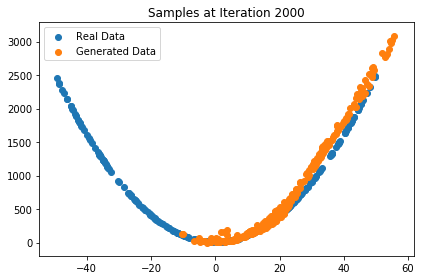

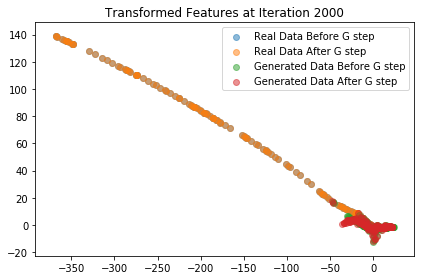

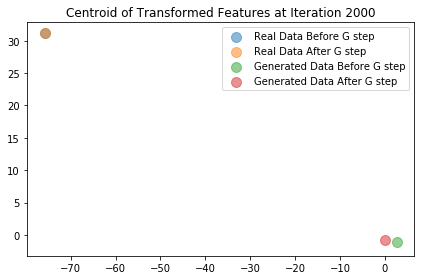

Iterations: 2100	 Discriminator loss: 0.9790	 Generator loss: 0.8659
Iterations: 2200	 Discriminator loss: 0.9950	 Generator loss: 0.8849
Iterations: 2300	 Discriminator loss: 1.0356	 Generator loss: 0.8358
Iterations: 2400	 Discriminator loss: 1.0276	 Generator loss: 0.7259
Iterations: 2500	 Discriminator loss: 0.9755	 Generator loss: 0.8675
Iterations: 2600	 Discriminator loss: 1.0155	 Generator loss: 0.8342
Iterations: 2700	 Discriminator loss: 0.9896	 Generator loss: 0.9641
Iterations: 2800	 Discriminator loss: 1.0151	 Generator loss: 0.8598
Iterations: 2900	 Discriminator loss: 1.0716	 Generator loss: 0.8077
Iterations: 3000	 Discriminator loss: 1.0596	 Generator loss: 0.8131


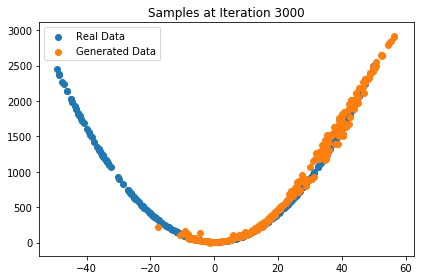

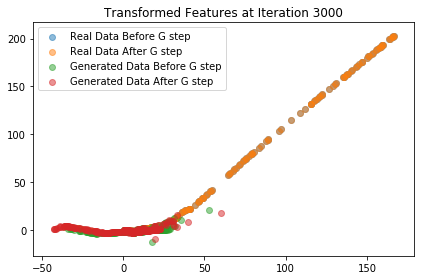

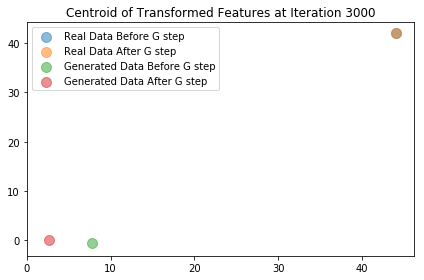

Iterations: 3100	 Discriminator loss: 0.9623	 Generator loss: 1.0727
Iterations: 3200	 Discriminator loss: 1.1051	 Generator loss: 0.8155
Iterations: 3300	 Discriminator loss: 1.1191	 Generator loss: 0.7493
Iterations: 3400	 Discriminator loss: 1.0195	 Generator loss: 0.9912
Iterations: 3500	 Discriminator loss: 1.1329	 Generator loss: 0.8597
Iterations: 3600	 Discriminator loss: 1.1247	 Generator loss: 1.0501
Iterations: 3700	 Discriminator loss: 1.1201	 Generator loss: 0.7543
Iterations: 3800	 Discriminator loss: 1.1763	 Generator loss: 0.7025
Iterations: 3900	 Discriminator loss: 1.2495	 Generator loss: 0.6949
Iterations: 4000	 Discriminator loss: 1.2777	 Generator loss: 0.6927


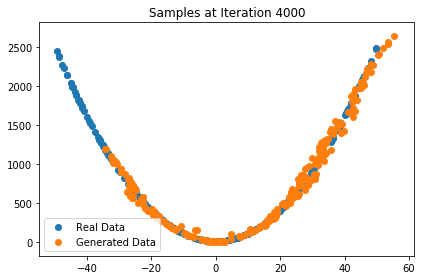

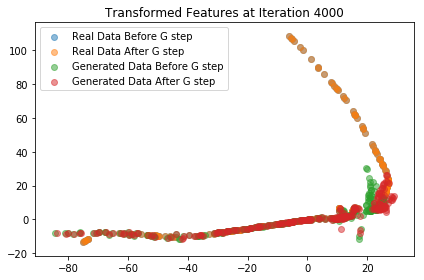

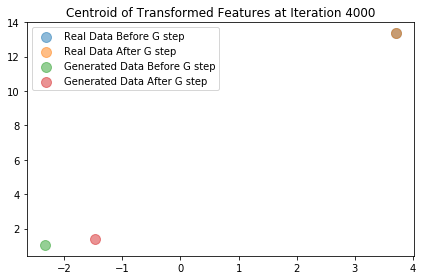

Iterations: 4100	 Discriminator loss: 1.3086	 Generator loss: 0.6588
Iterations: 4200	 Discriminator loss: 1.3462	 Generator loss: 0.7823
Iterations: 4300	 Discriminator loss: 1.3554	 Generator loss: 0.6476
Iterations: 4400	 Discriminator loss: 1.3494	 Generator loss: 0.6275
Iterations: 4500	 Discriminator loss: 1.3692	 Generator loss: 0.5821
Iterations: 4600	 Discriminator loss: 1.3732	 Generator loss: 0.6354
Iterations: 4700	 Discriminator loss: 1.3329	 Generator loss: 0.5563
Iterations: 4800	 Discriminator loss: 1.3682	 Generator loss: 0.6900
Iterations: 4900	 Discriminator loss: 1.2996	 Generator loss: 0.6970
Iterations: 5000	 Discriminator loss: 1.3286	 Generator loss: 0.5926


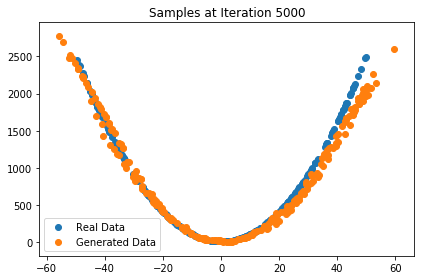

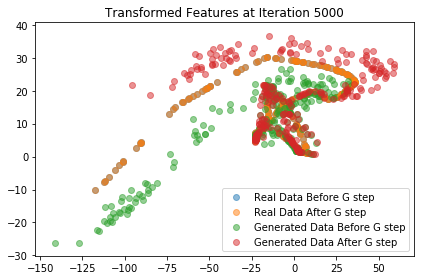

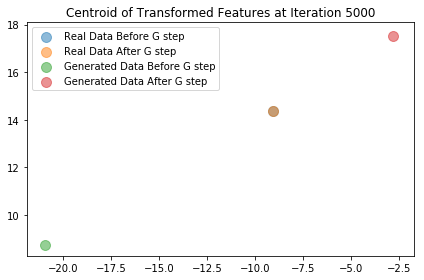

Iterations: 5100	 Discriminator loss: 1.3626	 Generator loss: 0.5862
Iterations: 5200	 Discriminator loss: 1.3400	 Generator loss: 0.6434
Iterations: 5300	 Discriminator loss: 1.3917	 Generator loss: 0.7147
Iterations: 5400	 Discriminator loss: 1.3742	 Generator loss: 0.7118
Iterations: 5500	 Discriminator loss: 1.3401	 Generator loss: 0.6974
Iterations: 5600	 Discriminator loss: 1.3707	 Generator loss: 0.6953
Iterations: 5700	 Discriminator loss: 1.3388	 Generator loss: 0.5198
Iterations: 5800	 Discriminator loss: 1.3859	 Generator loss: 0.6476
Iterations: 5900	 Discriminator loss: 1.3497	 Generator loss: 0.5556
Iterations: 6000	 Discriminator loss: 1.3690	 Generator loss: 0.6694


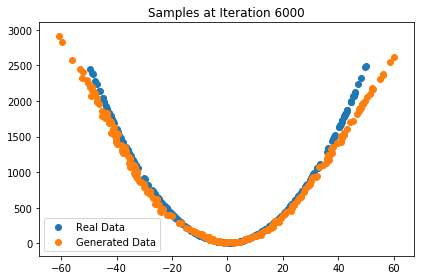

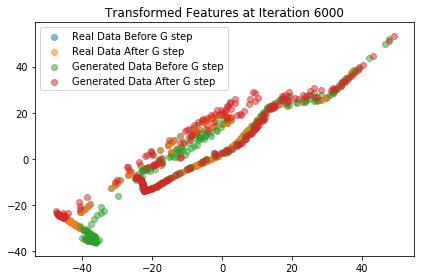

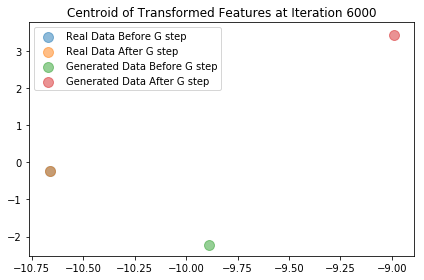

Iterations: 6100	 Discriminator loss: 1.3104	 Generator loss: 0.5560
Iterations: 6200	 Discriminator loss: 1.3746	 Generator loss: 0.7468
Iterations: 6300	 Discriminator loss: 1.3145	 Generator loss: 0.6535
Iterations: 6400	 Discriminator loss: 1.3272	 Generator loss: 0.7675
Iterations: 6500	 Discriminator loss: 1.3496	 Generator loss: 0.8210
Iterations: 6600	 Discriminator loss: 1.2922	 Generator loss: 0.5313
Iterations: 6700	 Discriminator loss: 1.3184	 Generator loss: 0.5050
Iterations: 6800	 Discriminator loss: 1.3479	 Generator loss: 0.5483
Iterations: 6900	 Discriminator loss: 1.3295	 Generator loss: 0.7454
Iterations: 7000	 Discriminator loss: 1.3632	 Generator loss: 0.5395


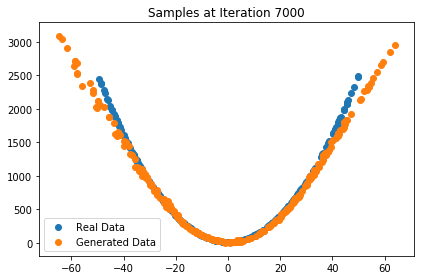

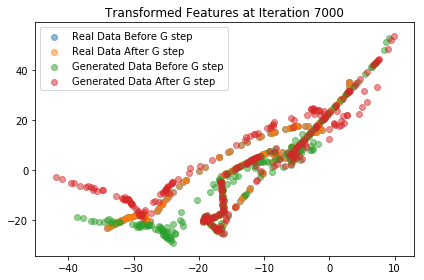

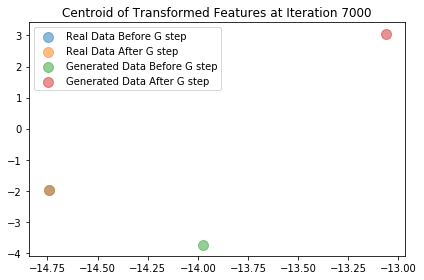

Iterations: 7100	 Discriminator loss: 1.2613	 Generator loss: 0.6126
Iterations: 7200	 Discriminator loss: 1.2481	 Generator loss: 0.6385
Iterations: 7300	 Discriminator loss: 1.2803	 Generator loss: 0.7102
Iterations: 7400	 Discriminator loss: 1.2839	 Generator loss: 0.5541
Iterations: 7500	 Discriminator loss: 1.3138	 Generator loss: 0.7419
Iterations: 7600	 Discriminator loss: 1.2641	 Generator loss: 0.7659
Iterations: 7700	 Discriminator loss: 1.3245	 Generator loss: 0.6180
Iterations: 7800	 Discriminator loss: 1.2740	 Generator loss: 0.7290
Iterations: 7900	 Discriminator loss: 1.2996	 Generator loss: 0.7213
Iterations: 8000	 Discriminator loss: 1.2620	 Generator loss: 0.6384


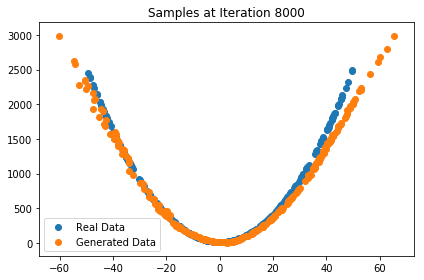

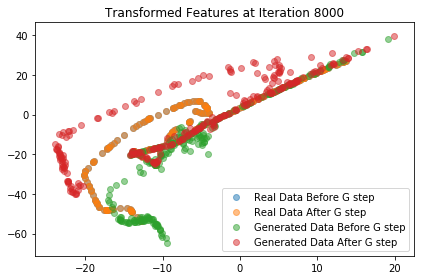

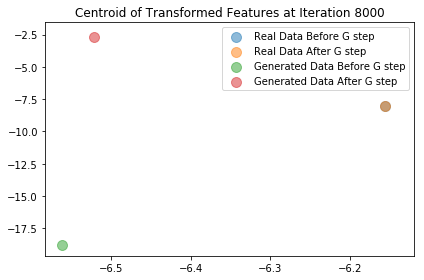

Iterations: 8100	 Discriminator loss: 1.2579	 Generator loss: 0.5010
Iterations: 8200	 Discriminator loss: 1.3263	 Generator loss: 0.7392
Iterations: 8300	 Discriminator loss: 1.2680	 Generator loss: 0.5027
Iterations: 8400	 Discriminator loss: 1.3519	 Generator loss: 0.4949
Iterations: 8500	 Discriminator loss: 1.3247	 Generator loss: 0.7263
Iterations: 8600	 Discriminator loss: 1.3034	 Generator loss: 0.5358
Iterations: 8700	 Discriminator loss: 1.2585	 Generator loss: 0.4462
Iterations: 8800	 Discriminator loss: 1.2718	 Generator loss: 0.4287
Iterations: 8900	 Discriminator loss: 1.1393	 Generator loss: 0.5845
Iterations: 9000	 Discriminator loss: 1.2680	 Generator loss: 0.6271


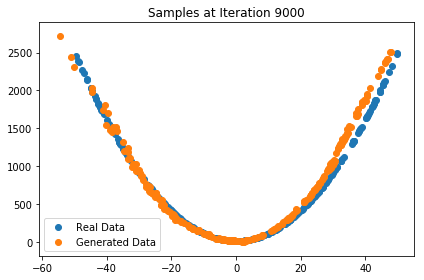

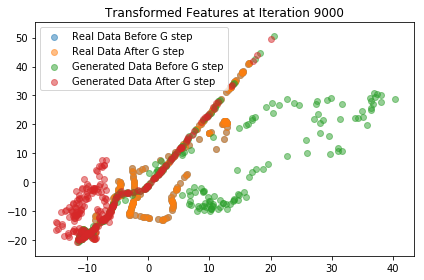

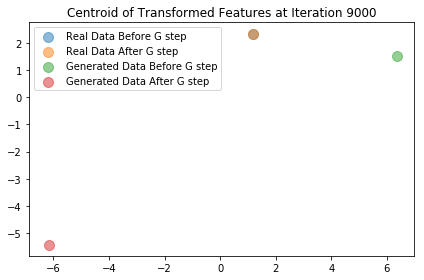

Iterations: 9100	 Discriminator loss: 1.2280	 Generator loss: 0.6108
Iterations: 9200	 Discriminator loss: 1.2765	 Generator loss: 0.7131
Iterations: 9300	 Discriminator loss: 1.2709	 Generator loss: 0.6830
Iterations: 9400	 Discriminator loss: 1.2162	 Generator loss: 0.6048
Iterations: 9500	 Discriminator loss: 1.2382	 Generator loss: 0.6536
Iterations: 9600	 Discriminator loss: 1.2142	 Generator loss: 0.4096
Iterations: 9700	 Discriminator loss: 1.2714	 Generator loss: 0.6854
Iterations: 9800	 Discriminator loss: 1.2599	 Generator loss: 0.6116
Iterations: 9900	 Discriminator loss: 1.2266	 Generator loss: 0.6151
Iterations: 10000	 Discriminator loss: 1.3465	 Generator loss: 0.4947


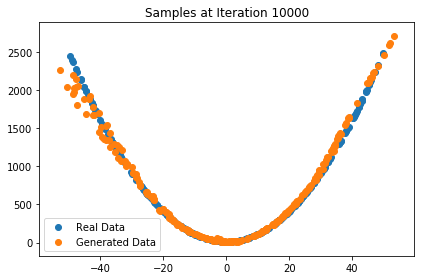

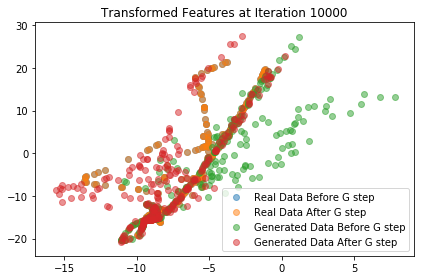

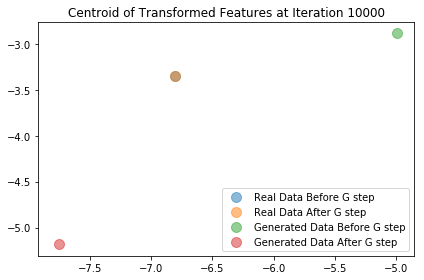

In [8]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
discriminator_steps = 10
generator_steps = 10

x_plot = sample_data(n=batch_size)

for i in range(10001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 2)

    for _ in range(discriminator_steps):
        _, d_loss = sess.run([disc_train_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    
    rh3_dstep, gh3_dstep = sess.run([r_h3, g_h3], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(generator_steps):
        _, g_loss = sess.run([gen_train_step, gen_loss], feed_dict={Z: Z_batch})

    rh3_gstep, gh3_gstep = sess.run([r_h3, g_h3], feed_dict={X: X_batch, Z: Z_batch})

    if i % 100 == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,d_loss,g_loss))
    
    if i%1000 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.show()
        plt.close()

        plt.figure()
        rrd = plt.scatter(rh3_dstep[:,0], rh3_dstep[:,1], alpha=0.5)
        rrg = plt.scatter(rh3_gstep[:,0], rh3_gstep[:,1], alpha=0.5)
        grd = plt.scatter(gh3_dstep[:,0], gh3_dstep[:,1], alpha=0.5)
        grg = plt.scatter(gh3_gstep[:,0], gh3_gstep[:,1], alpha=0.5)


        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.show()
        plt.close()
        plt.figure()

        rrdc = plt.scatter(np.mean(rh3_dstep[:,0]), np.mean(rh3_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rh3_gstep[:,0]), np.mean(rh3_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(gh3_dstep[:,0]), np.mean(gh3_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(gh3_gstep[:,0]), np.mean(gh3_gstep[:,1]),s=100, alpha=0.5)

        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))

        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.show()
        plt.close()

These graphs are awesome because we can see that the generator, after generating pretty much random noise after 1000 training iterations, begins to make quadratic-looking graphs after 4000 more, and by the end is almost perfect. The GAN at this stage 'understands' the task we wish it to. Applied to text-based tasks, which is incredibly more complex but fullfilling, can give us extremely valuable insights into the nature of fake reviews and the features that can be taken advantage to improve our discriminator much more.

(Will add explanations of the centroid and feature transformation graphs afterwards)